# Linear classifiers: `fit`

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2018 Winter Term 1

Mike Gelbart

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 16

from plot_classifier import plot_loss_diagram, plot_classifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

%autosave 0

Autosave disabled


### Admin

- Assignment 4 to be posted later today, due Friday of next week.
- Midterm grades posted.
  - Can view exam during Mark's or my office hours this week and next week.
- Bolasso question: follow-up.

### Last Time: Classification using Regression

- Binary classification using sign of linear models:

$$\hat{y}=\text{sign}(w^Tx_i)$$

- We talked about predictions and the interpretation of $w$.
- But what loss function do we use to learn $w$?

### Can we just use least squares???

- Consider training by minimizing squared error with $y_i$ like these: 

$$y=\begin{bmatrix}+1\\+1\\-1\\+1\\-1\end{bmatrix}$$


- If we predict $w^Tx_i = +0.9$ and $y_i = +1$ (correct), error is small: $(0.9 - 1)^2 = 0.01$.
- If we predict $w^Tx_i = -0.8$ and $y_i = +1$ (incorrect), error is big: $(-0.8 - 1)^2 = 3.24$.
- If we predict $w^Tx_i = +100$ and $y_i = +1$ (correct), error is huge: $(100 - 1)^2 = 9801$.

Least squares penalized for being "too right": $+100$ has the right sign, so the error should be zero (or tiny).

### Loss function diagrams

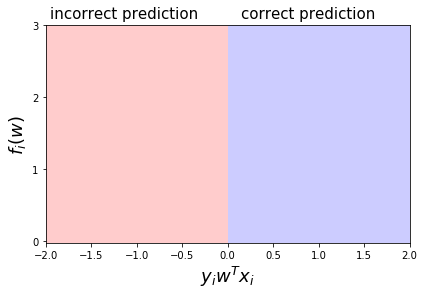

In [2]:
plot_loss_diagram()

- Above: this is what I call a "loss function diagram".
  - It is not straightforward!
  - Let's start with this table:

|      | $w^Tx_i$ negative | $w^Tx_i$ positive | 
|------|-------|-------|
| $y_i=-1$ (**negative**) | ✅  | ❌ | 
| $y_i=+1$ (**positive**) | ❌ | ✅  | 

Thus the prediction is correct if and only if $y_iw^Tx_i>0$.

### 0-1 loss

$$f(w)=\| \text{sign}(Xw)-y\|_0$$

- Below is the 0-1 loss, which, when added over examples, give the number of classification errors. 

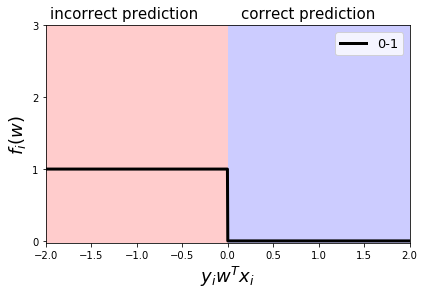

In [4]:
plot_loss_diagram()
grid = np.linspace(-2,2,1000)
plt.plot(grid, grid<0, color='black', linewidth=3, label="0-1")
plt.legend(loc="best", fontsize=13);

- We are now plotting the loss vs. $y_iw^Tx_i$ for a given training example.
  - This is totally different from plotting in the data space ($y_i$ and $x_i$).
- The overall loss is a sum over training examples.
  - We're plotting the individual loss **for a particular training example**. 
- The 0-1 loss is intuitive but **hard to minimize**.
  - Non convex, gradient is zero everywhere. 
  - Note, this is **not** the same type of problem we have with squared error and outliers!
    - That was a problem of the loss not reflecting what we want.
    - This is a problem of minimizing the loss.

### Squared loss

$$f(w) = ||Xw-y||^2$$

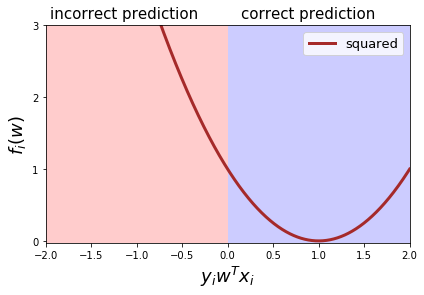

In [5]:
plot_loss_diagram()
grid = np.linspace(-2,2,1000)
plt.plot(grid, (grid-1)**2, color='brown', linewidth=3, label="squared")
plt.legend(loc="best", fontsize=13);

- This is not a good loss for classification!
  - It gets larger as you get "more correct" (right-hand side)

Note: with linear regression $y_i$ could be any number and thus the parabola could be centred anywhere. But here we've restricted ourselves to $y_i=\pm 1$.
  

### Logistic loss and hinge loss

- Below are two convex approximations to the 0-1 loss which are used a lot in practice. 
  - Logistic loss: $\log(1+\exp(-y_iw^Tx_i))$
  - Hinge loss: $\max(0, 1-y_iw^Tx_i)$

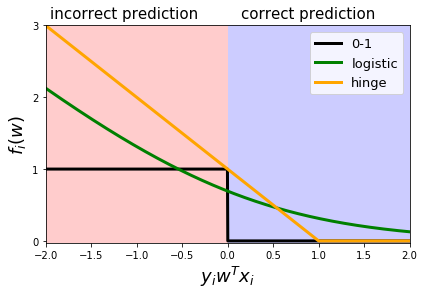

In [6]:
plot_loss_diagram()
plt.plot(grid, grid<0, color='black', linewidth=3, label="0-1")
plt.plot(grid, np.log(1+np.exp(-grid)), color='green', linewidth=3, label="logistic")
plt.plot(grid, np.maximum(0,1-grid), color='orange', linewidth=3, label="hinge")
plt.legend(loc="best", fontsize=13);

- These both make sense: they are small for correct predictions and large for incorrect predictions.
- The subtle difference between them has important implications.
- We'll explore this more now.

### Support Vector Machine (SVM)

$$f(w) =\sum_{i=1}^n\max\{0, 1-y_iw^Tx_i\} + \frac{\lambda}{2}\|w\|^2$$

- Hinge loss + L2 regularization

FAQ: Why not have the hinge at 0 instead of 1?

- In that case, we’d have a trivial solution at $w=0$
  - $f(0)=0$ and $f(w)\geq 0$ so $w=0$ minimizes $f$.
  - Putting the hinge at some positive value avoids this problem.
  - The "1" is arbitrary and is just an overall scaling factor for $w$.
  - See bonus slides for more info.

### Logistic regression

$$f(w) = \sum_{i=1}^n \log\left(1+\exp(-y_iw^Tx_i)\right)$$

- This is the "logistic loss" and model is called "logistic regression".
  - Convex and differentiable: minimize this with gradient descent.
  - You should also add regularization.
  - We’ll see later that the probabilities it outputs have a meaningful interpretation.

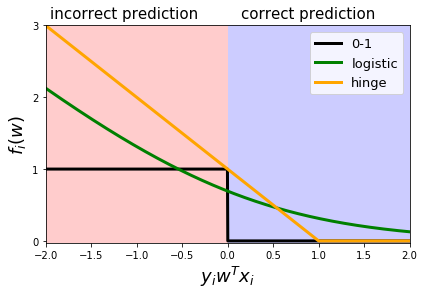

In [7]:
# repeat this picture
plot_loss_diagram()
plt.plot(grid, grid<0, color='black', linewidth=3, label="0-1")
plt.plot(grid, np.log(1+np.exp(-grid)), color='green', linewidth=3, label="logistic")
plt.plot(grid, np.maximum(0,1-grid), color='orange', linewidth=3, label="hinge")
plt.legend(loc="best", fontsize=13);

### Multiple choice question

Which of the following are true? (It may be multiple of them.)

1. The loss functions for logistic regression and SVM are both smooth.
2. If $y_iw^Tx_i>0$ then you've predicted correctly for training example $i$.
3. If your prediction is correct then the hinge loss is $0$ for that example.
4. The overall loss is the sum of the individual per-training-example losses (when there's no regularization).

### Support vectors

- Support vectors occur with the hinge loss when $y_iw^Tx_i < 1$.
- If something is **not** a support vector, then its loss is zero and it "doesn't contribute".

In [20]:
n = 20
X = np.random.randn(n,2)
y = np.random.choice((-1,+1),size=n)
X[y>0,0] -= 2
X[y>0,1] += 2

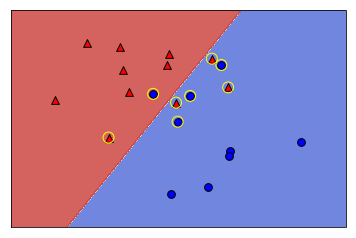

In [21]:
svm = SVC(kernel="linear", C=1e6)
svm.fit(X,y)

plt.figure()
plot_classifier(X,y,svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);

- The support vectors (SVs) are shown in yellow.
- These are the example that "support" the boundary. 

Below: let's try removing all other examples, keeping only the SVs.

In [22]:
sv = svm.support_
not_sv = list(set(range(n)) - set(sv))

[[-1.93577562  1.15638415]]
[[-1.93563088  1.1562165 ]]
The coefficients are the same!


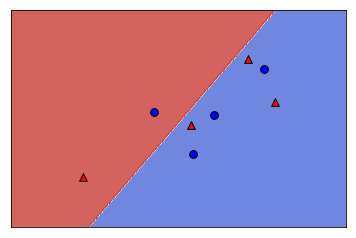

In [23]:
# remove all non-support vectors
X3 = np.delete(X,not_sv,0)
y3 = np.delete(y,not_sv,0)

svm3 = SVC(kernel="linear", C=1e6)
svm3.fit(X3,y3)

plot_classifier(X3,y3,svm3, ax=plt.gca())
# plt.scatter(*svm3.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
print(svm.coef_)
print(svm3.coef_)
print("The coefficients are the same!")

Below: let's try removing a support vector from the original classifier.

In [24]:
# remove a support vector
X2 = np.delete(X,sv[0],0)
y2 = np.delete(y,sv[0],0)

svm2 = SVC(kernel="linear", C=1e6)
svm2.fit(X2,y2);

[[-1.93577562  1.15638415]]
[[-0.81248782  0.72181925]]


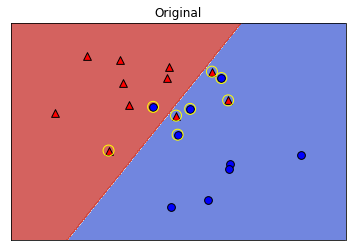

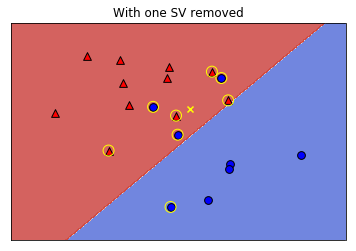

In [25]:
plt.figure()
plot_classifier(X,y,svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.title("Original");

plt.figure()
plot_classifier(X2,y2,svm2, ax=plt.gca())
plt.scatter(*svm2.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.scatter(svm.support_vectors_[0,0], svm.support_vectors_[0,1], marker="x", c="yellow")
plt.title("With one SV removed");

print(svm.coef_)
print(svm2.coef_)

### Max margin

- You should know the word "margin" because you might hear it
- Personally I believe this is not the best way to understand SVM
- Thus the following is mainly for completeness
- More on max-margin in the bonus slides

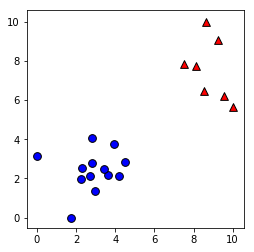

In [26]:
# create a data set that is (hopefully) linearly separable
np.random.seed(0)
X = np.random.randn(n,2)
X[:,0] -= np.min(X[:,0])
X[:,0] /= np.max(X[:,0])
X[:,1] -= np.min(X[:,1])
X[:,1] /= np.max(X[:,1])
labels = (-1,+1)
y = np.random.choice(labels,size=n)
X[y>0] += 1
X *= 5

plt.scatter(X[y==labels[0],0], X[y==labels[0],1], cmap=plt.cm.coolwarm, s=60, c='b', marker='o', edgecolors='k');
plt.scatter(X[y==labels[1],0], X[y==labels[1],1], cmap=plt.cm.coolwarm, s=60, c='r', marker='^', edgecolors='k');
plt.axis('equal');
plt.axis('square');

- The above data set is called **linearly separable** because it can be perfectly separated by a linear boundary.
- Perceptron algorithm finds some classifier with zero error.
- But are all zero-error classifiers equally good?

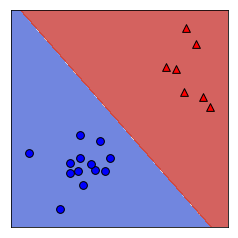

In [27]:
lr = LogisticRegression(C=1) # fit a logistic regression to it
lr.fit(X,y)
plt.figure()
plot_classifier(X,y,lr,ax=plt.gca());
plt.axis('equal');
plt.axis('square');

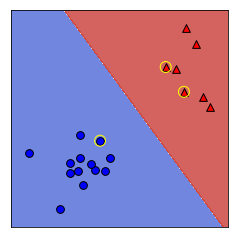

In [28]:
svm = SVC(kernel="linear", C=1) # fit an SVM to it
svm.fit(X,y)
plt.figure()
plot_classifier(X, y, svm, ax=plt.gca());
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.axis('equal');
plt.axis('square');

- The **margin** is the distance from the boundary to the nearest point(s).
- Maximizing the margin is a "maximin" problem: maximize the minimum distance to the boundary.
- Intuitively, more margin is good because it leaves more "room" before we make an error.
- Above: it looks like SVM maximizes the margin whereas logistic regression doesn't.
- It turns out this can be proven to be exactly true (see bonus slides).

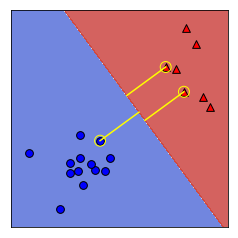

In [29]:
plt.figure()
plot_classifier(X, y, svm, ax=plt.gca());
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.axis('equal');
plt.axis('square');

def SV_proj(svm):
    v = svm.support_vectors_
    s = np.array([svm.coef_.flatten()[1], -svm.coef_.flatten()[0]])
    w = svm.coef_
    return (v@s[:,None])/(s@s) * s - w/(w@w.T)*svm.intercept_
proj = SV_proj(svm)

for i in range(len(proj)):
    p = proj[i]
    sv = svm.support_vectors_[i]
    plt.plot((p[0],sv[0]),(p[1],sv[1]), 'yellow')

Reasons I don't think this max-margin stuff is particularly interesting:

- Your data set will probably not be linearly separable
- Logistic regression will probably behave the same without regularization (extremely large `C`).
- The proof that max margin is equivalent to hinge loss + L2 regularization is very confusing.

(Bonus) This reminds me of KNN with $k=1$, since the boundary will always be half way between examples of different labels:

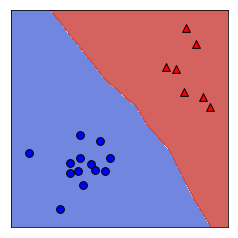

In [30]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X,y)
plt.figure();
plot_classifier(X, y, knn, ax=plt.gca());
plt.axis('equal');
plt.axis('square');

### Multiple choice question (tricky - to read over later)

Which of the following are true? (It may be multiple of them.)

1. If the dataset is linearly separable, then one can find weights such that the total hinge loss ("un-regularized SVM") is zero.
2. If the dataset is linearly separable, then one can find weights such that the total logistic loss (un-regularized logistic regression) is zero.
3. If the dataset is linearly separable, then an SVM (hinge loss + L2 regularization) will make no errors on the training set.
4. If the dataset is linearly separable, then L2-regularized logistic regression (logistic loss + L2 regularization) will make no errors on the training set.

Reminders:

- Hinge Loss: $f(w) =\sum_{i=1}^n\max\{0, 1-y_iw^Tx_i\}$
- Logistic Loss: $f(w) = \sum_{i=1}^n \log\left(1+\exp(-y_iw^Tx_i)\right)$

### Probabilities

- It is not particularly natural to get probabilities out of SVMs, although one could devise ways of doing so.

### Regularization

- Larger $\lambda$ makes the coefficients smaller as usual.
- More intution on this coming when we get to kernels.

### Why people use linear classifiers

Logistic regression and SVMs are used EVERYWHERE!

- Fast training and testing.
  - Training on huge datasets using "stochastic" gradient descent (coming soon).
  - Testing is just computing $w^Tx_i$.
  - (For now we haven’t said how to minimize the SVM loss since it's not smooth)
- Weights wj are easy to understand. 
  - It's how much $x_j$ changes the prediction and in what direction.
- We can often get a good test error.
  - With low-dimensional features using RBF basis and regularization. 
  - With high-dimensional features and regularization.
- Smoother predictions than random forests.

[Fernandez-Delgado et al. 2014](http://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf):

- Compared 179 classifiers on 121 datasets.
- Random forests are most likely to be the best classifier.
- Next best class of methods was SVMs (L2-regularization, RBFs).

### Comparison of logistic regression vs. SVM



| Logistic regression  | SVM |
|----------------------|--------|
| a linear classifier | also a linear classifier (at least for the "linear SVM" covered today) |
| convex objective | also convex |
| smooth objective, can use gradient descent | non-smooth objective, need other methods |
| naturally outputs meaningful probabilities (Maximum Likelihood lecture) | no clear probabilistic interpretation |
| can use with L2, L1 regularization, etc. | the name implies using L2 regularization |
| less computationally efficient with kernels (Kernels lecture) | more computationally efficient with kernels (Kernels lecture)
| a component of neural networks (Deep Learning lectures) | not particularly relevant to neural networks (Deep Learning lectures) |

### Summary

- Hinge loss is a convex upper bound on 0-1 loss.
  - SVMs add L2-regularization, can be viewed as "maximizing the margin".
- Logistic loss is a smooth convex approximation to the 0-1 loss.
  - "Logistic regression".
- SVMs and logistic regression are very widely-used.
  - A lot of ML consulting: "find good features, use L2-regularized logistic regression".
- Both are just linear classifiers (a hyperplane dividing into two halfspaces).

### Preview of upcoming lectures

- Wednesday: multi-class classification with linear classifiers
- Friday/Monday: kernel methods

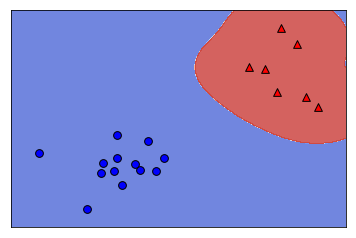

In [31]:
svm = SVC() # RBF kernel by default
svm.fit(X,y)

plot_classifier(X,y,svm);